# Evaluating model and interpret the classification results

In [1]:
import torchray
import torch
import attr
from pathlib import Path
from torchvision import datasets, transforms
from torchray.benchmark import get_example_data, plot_example
from torchvision import models
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics as sk_metrics
from torchray.attribution.guided_backprop import GuidedBackpropReLU
from torchray.attribution.common import Probe, get_module
from torchray.attribution.grad_cam import grad_cam
from torchray.attribution.grad_cam import gradient_to_grad_cam_saliency
from PIL import Image
import cv2

In [3]:
labels_bin = {"abnormal": ["A", "a", "J", "S", "V", "E", "F", "P", "/", "f", "Q"], "normal": ["N", "L", "R", "e", "j"]}

In [4]:
labels_multi = {"SVEB": ["A", "a", "J", "S"], "VEB": ["V", "E"], "F": ["F"], "Q": ["P", "/", "f", "Q"], "N": ["N", "L", "R", "e", "j"]}

In [27]:
# CHECK THIS!!!
beat = "final"

In [1]:
MULTI = True
if MULTI:
    for label in labels_multi:
        Path(f"../Grad_CAM_maps/MULTI_label_{beat}_beat/{label}").mkdir(parents=True)
else:
    for label in labels_bin:
        Path(f"../Grad_CAM_maps/label_{beat}_beat/{label}").mkdir(parents=True)

NameError: name 'labels_multi' is not defined

In [2]:
@attr.s(auto_attribs=True)
class DataPreparation:
    data_dir: Path
    device: str = attr.ib(default=torch.device("cuda:0" if torch.cuda.is_available() else "cpu"), init=False)

    @staticmethod
    def data_transformations():
        data_transforms = {
            'test': transforms.Compose([
                transforms.CenterCrop((200, 1500)),
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        }
        return data_transforms
    
    def create_dataloaders(self, batch_size, shuffle, num_workers):
        data_transforms = self.data_transformations()
        
        image_datasets = {
            'test': datasets.ImageFolder(self.data_dir, data_transforms['test'])
        }
        dataloaders = {
            'test': torch.utils.data.DataLoader(image_datasets['test'], batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
        }
        dataset_sizes = {
            'test': len(image_datasets['test'])
        }
        return dataloaders, dataset_sizes


# Iterate over all heartbeats + multiclass case and create the grad cam maps (folders must be created)

In [3]:
def deprocess(image):
    transform = transforms.Compose([
        transforms.Normalize(mean=[0, 0, 0], std=[4.3668, 4.4643, 4.4444]),
        transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1, 1, 1]),
        transforms.ToPILImage(),
    ])
    return transform(image)

def show_img(PIL_IMG):
    plt.imshow(np.asarray(PIL_IMG))

In [4]:
def grad_cam_maps(data, variant):
    classes = data["test"].dataset.classes
    i = 0
    for inputs, labels in data['test']:
        inputs = inputs.to(0)
        labels = labels.to(0)
        x = inputs
    #     break
        x.requires_grad_();
        saliency_layer = get_module(model, model.layer4)
        probe = Probe(saliency_layer, target='output')
        y = model(x)
        score_max_index = y.argmax(dim=1)
        z = y[:, score_max_index]
        z.backward(torch.ones_like(z))
        saliency = gradient_to_grad_cam_saliency(probe.data[0])

        for index in range(len(saliency)): 
            plt.figure()
            heatmap = np.float32(saliency[index, 0].cpu().detach())
            img = np.array(deprocess(x[index].cpu().detach()))

            heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
            heatmap = np.uint8(255 * heatmap)

            img1 = plt.imshow(heatmap, alpha=.7)
            img2 = plt.imshow(img, alpha=.8)

            plt.axis('off')
            
            label = classes[labels[index]]
            
            ### CHANGE NAME!!!!!!!
            if variant == "multiclass":
                plt.savefig(f"../Grad_CAM_maps/MULTI_label_final_beat/{label}/{i}_{index}.png")
            else:
                plt.savefig(f"../Grad_CAM_maps/label_{variant}_beat/{label}/{i}_{index}.png")
            plt.close()
        i += 1

In [9]:
# variants = ["final", "mid", "initial",  "multiclass"]
# models = ["resnet50_d_02_t_20_10_final_beat", "resnet50_d_02_t_22_52_mid_beat", "resnet50_d_02_t_20_28_initial_beat", "resnet50_d_05_t_00_40"]

variants = ["initial",  "multiclass"]
models = ["resnet50_d_02_t_20_28_initial_beat", "resnet50_d_05_t_00_40"]
data_prep = DataPreparation(f'../data/figures_{variants[0]}/test')
data, size = data_prep.create_dataloaders(16, False, 4)

initial


KeyboardInterrupt: 

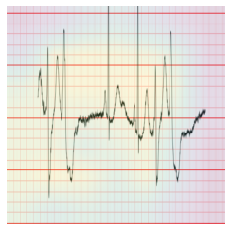

In [10]:
for i, variant in enumerate(variants):
    print(variant)
    data_prep = DataPreparation(f'../data/figures_{variant}/test')
    data, size = data_prep.create_dataloaders(16, False, 4)
    model_path = Path().cwd().parents[0] / f"models/{models[i]}.pth"
    model = torch.load(model_path)
    model.eval();
    grad_cam_maps(data, variant)

In [ ]:
data_prep = DataPreparation(f'../data/figures_{beat}/test')
data, size = data_prep.create_dataloaders(16, False, 4)model_path = Path().cwd().parents[0] / f"models/resnet50_d_02_t_20_10_{beat}_beat.pth"
model = torch.load(model_path)
model.eval();

-------------------------------------------------------------------------------------------------

# Grad CAM

In [9]:
saliency_layer = get_module(model, model.layer4)
probe = Probe(saliency_layer, target='output')
y = model(x)
score_max_index = y.argmax(dim=1)
z = y[:, score_max_index]
z.backward(torch.ones_like(z))

torch.Size([16, 2048, 7, 7])


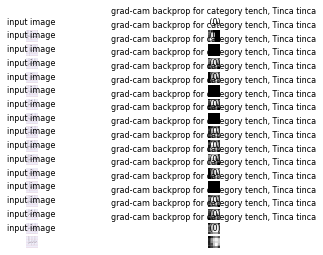

In [10]:
print(probe.data[0].size())
saliency = gradient_to_grad_cam_saliency(probe.data[0])
# Plots.
plot_example(x, saliency, 'grad-cam backprop', labels, save_path='saliency.pdf')

In [11]:
saliency.size()

torch.Size([16, 1, 7, 7])

In [12]:
index = 0

(224, 224, 3) (7, 7)
<class 'numpy.ndarray'> (224, 224)


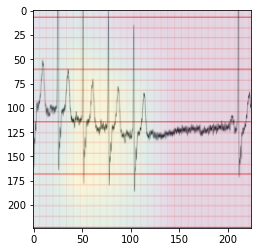

In [13]:
heatmap = np.float32(saliency[index, 0].cpu().detach())
img = np.array(deprocess(x[index].cpu().detach()))

print(img.shape, heatmap.shape)

heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)

print(type(heatmap), heatmap.shape)

plt.imshow(heatmap, alpha=.7)
plt.imshow(img, alpha=.8)
plt.show()

# heatmap = cv2.applyColorMap(cv2.UMat(heatmap), cv2.COLORMAP_JET)
# print(type(heatmap))
# # superimposed_img = heatmap * 0.4 + img
# superimposed_img = cv2.addWeighted(img, .4, heatmap, .4, 0)
# cv2.imwrite('./map.jpg', superimposed_img)

### Guided Back Propagation

In [5]:
def deprocess_image_gb(img):
    """ see https://github.com/jacobgil/keras-grad-cam/blob/master/grad-cam.py#L65 """
    img = img - np.mean(img)
    img = img / (np.std(img) + 1e-5)
    img = img * 0.1
    img = img + 0.5
    img = np.clip(img, 0, 1)
    return np.uint8(img*255)

In [6]:
gb = GuidedBackpropReLU(model)

NameError: name 'model' is not defined

In [ ]:
gb_model = GuidedBackpropReLUModel(model=model.cpu())
i = 0
for inputs, labels in data['test']:
    inputs = inputs.to(0)
    labels = labels.to(0)
    x = inputs
    break
    x.requires_grad_();
    saliency_layer = get_module(model, model.layer4)
    probe = Probe(saliency_layer, target='output')
    y = model(x)
    score_max_index = y.argmax(dim=1)
    z = y[:, score_max_index]
    z.backward(torch.ones_like(z))
    saliency = gradient_to_grad_cam_saliency(probe.data[0])
    
    for index in range(len(saliency)): 
        plt.figure()
        heatmap = np.float32(saliency[index, 0].cpu().detach())
        img = np.array(deprocess(x[index].cpu().detach()))

        heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
        heatmap = np.uint8(255 * heatmap)
        cam_mask = cv2.merge([heatmap, heatmap, heatmap])
        
        gb = gb_model(x[index].unsqueeze(0).cpu(), target_category=labels[index].cpu())
        gb = gb.transpose((1, 2, 0))
        cam_gb = deprocess_image_gb(cam_mask*gb)


        img1 = plt.imshow(cam_gb)
        
        plt.axis('off')
        if labels[index] == 0:
            label = "abnormal"
        else:
            label = "normal"
        ### CHANGE NAME!!!!!!!
        plt.savefig(f"../GB_Grad_CAM_maps/label_{beat}_beat/{label}/{i}_{index}.png")
        plt.close()
        
    i += 1

In [ ]:
cam_mask = cv2.merge([heatmap, heatmap, heatmap])
gb_model = GuidedBackpropReLUModel(model=model.cpu())

In [ ]:
index = 15

In [ ]:
gb = gb_model(x[index].unsqueeze(0).cpu(), target_category=labels[index].cpu())
gb = gb.transpose((1, 2, 0))

In [ ]:
cam_gb = deprocess_image_gb(cam_mask*gb)

In [ ]:
plt.imshow(cam_gb)
plt.show()